Spoken digit recognition using the Free Spoken Digit Dataset (FSDD)

At first, import packages to be used for the experiments

In [2]:
import glob
import os
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, cross_validate

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
from sklearn.cluster import MiniBatchKMeans, Birch
from sklearn.utils import shuffle
from joblib import Parallel, delayed, dump, load
from pyrcn.echo_state_network import SeqToLabelESNClassifier
from pyrcn.base import PredefinedWeightsInputToNode, NodeToNode
from pyrcn.metrics import accuracy_score, classification_report, confusion_matrix
from pyrcn.model_selection import SequentialSearchCV
import matplotlib
from matplotlib import pyplot as plt
#Options
plt.rc('image', cmap='RdBu')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import librosa
import librosa.display

Print number of files that are included in the dataset

In [3]:
all_files = glob.glob(r"E:\free-spoken-digit-dataset\recordings\*.wav")
print(len(all_files))

3000


Feature visualization

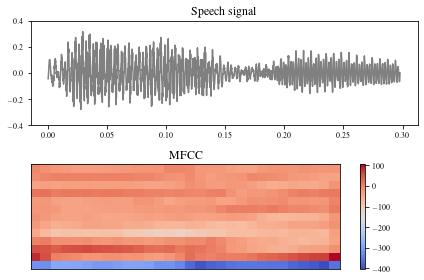

In [4]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
# X = np.vstack((mfcc, mfcc_delta, mfcc_delta2))
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(2, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(2, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

Extract features and labels from all signals

In [5]:
X_train = []
X_test = []
y_train = []
y_test = []
print("extracting features...")
for k, f in enumerate(all_files):
    basename = os.path.basename(f).split('.')[0]
    # Get label (0-9) of recording.
    label = int(basename.split('_')[0])
    idx = int(basename.split('_')[2])
    # Load the audio signal and normalize it.
    x, sr = librosa.core.load(f, sr=None, mono=False)
    # x /= np.max(np.abs(x))
    mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    if idx <= 4:
        X_test.append(mfcc.T)
        y_test.append(label)
    else:
        X_train.append(mfcc.T)
        y_train.append(label)
print("done!")

extracting features...
done!


## Normalize all features using the StandardScaler from scikit-learn."

In [6]:
scaler = StandardScaler().fit(X=np.vstack(X_train))
X_train_scaled = np.empty(shape=(len(X_train),), dtype=object)
X_test_scaled = np.empty(shape=(len(X_test),), dtype=object)
y_train = np.array(y_train, dtype=object)
X_train, X_train_scaled, y_train = shuffle(X_train, X_train_scaled, y_train)
y_test = np.array(y_test, dtype=object)
for k in range(len(X_train)):
    X_train_scaled[k] = scaler.transform(X_train[k])
    y_train[k] = np.atleast_1d(y_train[k]).astype(int)
for k in range(len(X_test)):
    X_test_scaled[k] = scaler.transform(X_test[k])
    y_test[k] = np.atleast_1d(y_test[k]).astype(int)

Validate training and test sizes

In [7]:
print(len(X_train), len(y_train), X_train[0].shape, y_train[0])
print(len(X_test), len(y_test), X_test[0].shape, y_test[0])

2700 2700 (45, 13) [6]
300 300 (30, 13) [0]


Feature visualization

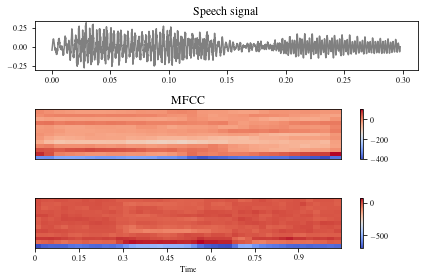

In [8]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(3, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
# plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(3, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(X_train[0].T, x_axis='time')
plt.colorbar()
plt.tight_layout()

In [34]:
from sklearn.neural_network import MLPRegressor
initially_fixed_params = {'hidden_layer_sizes': (50, ),
                          'activation': 'relu',
                          'random_state': 42}

mlp_enc = MLPRegressor(hidden_layer_sizes=(50, ) activation='relu', random_state=42).fit(np.concatenate(X_train_scaled), np.concatenate(X_train_scaled))

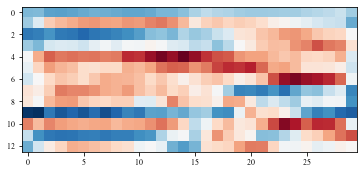

In [35]:
plt.imshow(X_test_scaled[0].T)

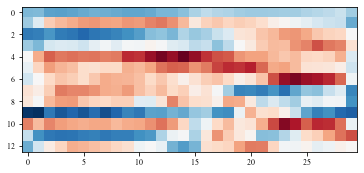

In [36]:
plt.imshow(mlp_enc.predict(X_test_scaled[0]).T)

In [42]:
initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': np.linspace(0.1, 1.0, 10),
                    'spectral_radius': np.linspace(0.0, 1.0, 11)}

step2_esn_params = {'leakage': np.linspace(0.1, 1.0, 10)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0]}

kwargs = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', GridSearchCV, step1_esn_params, kwargs),
            ('step2', GridSearchCV, step2_esn_params, kwargs),
            ('step3', GridSearchCV, step3_esn_params, kwargs),
            ('step4', GridSearchCV, step4_esn_params, kwargs)]

w_in = np.divide(mlp_enc.coefs_[0], np.linalg.norm(mlp_enc.coefs_[0], axis=0)[None, :])

base_esn = SeqToLabelESNClassifier(input_to_node=PredefinedWeightsInputToNode(predefined_input_weights=w_in),
                                   **initially_fixed_params)

try:
    sequential_search = load("sequential_search_enc.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train_scaled, y_train)
    dump(sequential_search, "sequential_search_enc.joblib")

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed: 20.7min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  2.1min finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  2.0min finished


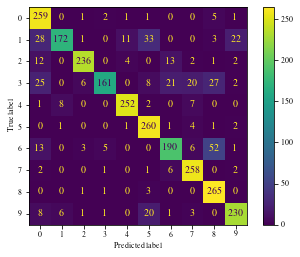

Classification training report for estimator SeqToLabelESNClassifier(input_to_node=PredefinedWeightsInputToNode(bias_scaling=1.0,
                                                                   input_activation='identity',
                                                                   input_scaling=0.30000000000000004,
                                                                   predefined_input_weights=array([[-0.21722455,  0.21671072, -0.16822506, -0.17157664,  0.23179956,
         0.08013764,  0.2316542 ,  0.62646986,  0.1538077 , -0.20250126,
        -0.25307936,  0.69035135,  0.05105275,  0.00843211, -0.23168108,
        -0...
         0.60566325,  0.41444402,  0.16921268,  0.00225809, -0.05136088,
         0.47078896,  0.20017208, -0.17349911, -0.0931454 , -0.16875862,
        -0.48320937, -0.24593096, -0.25065031, -0.09110927, -0.32605403,
         0.11138711, -0.09097813,  0.0487236 ,  0.17290258, -0.16503102]])),
                        node_to_node=NodeToNode(hid

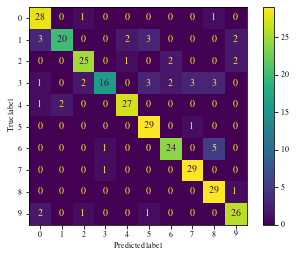

Classification test report for estimator SeqToLabelESNClassifier(input_to_node=PredefinedWeightsInputToNode(bias_scaling=1.0,
                                                                   input_activation='identity',
                                                                   input_scaling=0.30000000000000004,
                                                                   predefined_input_weights=array([[-0.21722455,  0.21671072, -0.16822506, -0.17157664,  0.23179956,
         0.08013764,  0.2316542 ,  0.62646986,  0.1538077 , -0.20250126,
        -0.25307936,  0.69035135,  0.05105275,  0.00843211, -0.23168108,
        -0...
         0.60566325,  0.41444402,  0.16921268,  0.00225809, -0.05136088,
         0.47078896,  0.20017208, -0.17349911, -0.0931454 , -0.16875862,
        -0.48320937, -0.24593096, -0.25065031, -0.09110927, -0.32605403,
         0.11138711, -0.09097813,  0.0487236 ,  0.17290258, -0.16503102]])),
                        node_to_node=NodeToNode(hidden_

In [43]:
esn = sequential_search.best_estimator_
y_pred_train = esn.predict(X=X_train_scaled)
cm = confusion_matrix(y_train, y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
plt.show()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(y_train, y_pred_train, digits=10)))

y_pred_test = esn.predict(X=X_test_scaled)
cm = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
plt.show()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(y_test, y_pred_test, digits=10)))

In [46]:
param_grid = {'hidden_layer_size': [50, 100, 200, 400, 500, 1000, 2000, 4000]}
print("CV results\tFit time\tInference time\tAccuracy score\tSize[Bytes]")
for params in ParameterGrid(param_grid):
    mlp_enc = MLPRegressor(hidden_layer_sizes=params['hidden_layer_size'], activation='relu', random_state=42).fit(np.concatenate(X_train_scaled), np.concatenate(X_train_scaled))
    w_in = np.divide(mlp_enc.coefs_[0], np.linalg.norm(mlp_enc.coefs_[0], axis=0)[None, :])
    base_esn = clone(sequential_search.best_estimator_)
    base_esn.input_to_node = PredefinedWeightsInputToNode(predefined_input_weights=w_in)
    base_esn.set_params(**params)
    esn_cv = cross_validate(clone(base_esn), X=X_train_scaled, y=y_train, 
                            scoring=make_scorer(accuracy_score), n_jobs=-1)
    esn = clone(base_esn).fit(X_train_scaled, y_train, n_jobs=8)
    acc_score = accuracy_score(y_test, esn.predict(X_test_scaled))
    print("{0}\t{1}".format(esn_cv, acc_score))

CV results	Fit time	Inference time	Accuracy score	Size[Bytes]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.3s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.0s finished


{'fit_time': array([10.49891925, 10.51796961, 10.96967125, 11.59032297, 11.26846552]), 'score_time': array([2.15673614, 2.37982869, 2.06849909, 2.08004737, 1.86245322]), 'test_score': array([0.75925926, 0.75740741, 0.78333333, 0.81851852, 0.77407407])}	0.8266666666666667


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.3s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished


{'fit_time': array([10.58665347, 11.94526505, 10.9696641 , 11.25442958, 12.00993776]), 'score_time': array([2.65606308, 1.8604486 , 2.58938575, 2.25549626, 2.09055972]), 'test_score': array([0.89444444, 0.87222222, 0.89074074, 0.89074074, 0.88333333])}	0.9


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.8s remaining:    4.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.8s finished


{'fit_time': array([13.51949358, 13.40536237, 13.21484518, 12.47522569, 13.73758364]), 'score_time': array([2.56177711, 2.54226017, 2.81251144, 2.94780803, 2.3587389 ]), 'test_score': array([0.94814815, 0.95      , 0.94444444, 0.94444444, 0.9462963 ])}	0.96


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.5s remaining:    7.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.5s finished


{'fit_time': array([18.31250715, 17.93969369, 17.92640471, 18.17589569, 17.03335023]), 'score_time': array([2.85001826, 2.75632858, 2.88216496, 2.48159695, 2.96287942]), 'test_score': array([0.97592593, 0.98333333, 0.96666667, 0.95740741, 0.97222222])}	0.9833333333333333


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.8s remaining:    9.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.8s finished


{'fit_time': array([23.15895224, 21.81910849, 22.90533805, 22.6667726 , 23.43782163]), 'score_time': array([2.67711926, 2.76787424, 3.12631512, 3.18296385, 2.71772647]), 'test_score': array([0.97962963, 0.98703704, 0.97777778, 0.97222222, 0.97407407])}	0.99


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   18.7s remaining:   31.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   20.2s finished


{'fit_time': array([75.6469295 , 73.62882209, 74.07773161, 73.66011596, 73.95257878]), 'score_time': array([3.66881132, 4.05932593, 4.17262697, 4.26286912, 4.08439493]), 'test_score': array([0.98333333, 0.99074074, 0.98888889, 0.98518519, 0.98333333])}	0.98


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.2min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.2min finished


{'fit_time': array([280.62688112, 279.74191093, 280.4990263 , 279.54462242,
       280.55718064]), 'score_time': array([6.63114905, 7.08070159, 7.12931585, 7.02254748, 6.62408066]), 'test_score': array([0.98703704, 0.99444444, 0.9962963 , 0.98888889, 0.99444444])}	0.99


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  4.5min remaining:  7.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  4.6min finished


{'fit_time': array([1086.54582095, 1089.37936282, 1088.1103332 , 1088.60087061,
       1086.57613206]), 'score_time': array([14.93619084, 13.72016668, 14.70105696, 13.82821822, 15.15326571]), 'test_score': array([0.99259259, 0.9962963 , 0.9962963 , 0.98703704, 0.99259259])}	0.9933333333333333
